In [1]:
# NUTS test using addit

In [2]:
from addit.dit import rundit
import jax.numpy as jnp
import numpy as np
from addit.ncf import inc3D

In [3]:
np.random.seed(0)

In [4]:
N=10000
Ng_nu=20000
Ng_beta=10
Ng_gammaL=10

nus=np.linspace(2050.0,2250.0,Ng_nu) #nu grid
beta_grid=np.logspace(-2,4,Ng_beta) #beta grid
gammaL_grid=np.logspace(-2,4,Ng_gammaL)#gammaL grid
S=np.logspace(0.0,2.0,N)
S[0:10]=1000.0

In [5]:
nu_lines=np.random.rand(N)*(nus[-1]-nus[0]-50.0)+nus[0]+25.0
beta=np.random.rand(N)*1.0
gammaL=np.random.rand(N)*1.0

In [6]:
F0in=rundit(S,nu_lines,beta,gammaL,nus,beta_grid,gammaL_grid)

In [7]:
F0obs=F0in+np.random.normal(size=len(nus))*np.median(F0in)*0.05 #5%

In [8]:
import matplotlib.pyplot as plt 

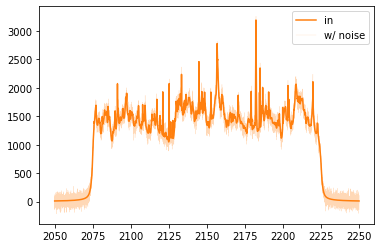

In [9]:
plt.plot(nus,F0in,color="C1",label="in")
plt.plot(nus,F0obs,alpha=0.3,lw=0.3,color="C1",label="w/ noise")
plt.legend()
plt.show()

In [10]:
import arviz
import numpyro.distributions as dist
import numpyro
from numpyro.infer import MCMC, NUTS
from numpyro.infer import Predictive
from numpyro.diagnostics import hpdi

In [11]:
def model_c(nu,y):
    sigma = numpyro.sample('sigma', dist.Exponential(np.median(F0in)*0.05))
    T = numpyro.sample('T', dist.Exponential(0.01))
    mu=rundit(S,nu_lines,beta*jnp.sqrt(T),gammaL,nus,beta_grid,gammaL_grid)
    
    numpyro.sample('y', dist.Normal(mu, sigma), obs=y)

In [14]:
from jax import random
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
num_warmup, num_samples = 100, 200

In [17]:
kernel = NUTS(model_c,forward_mode_differentiation=True)
mcmcx = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples)
mcmcx.run(rng_key_, nu=nus, y=F0obs)

KeyboardInterrupt: 

In [16]:
mcmcx.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         T      1.01      0.01      1.01      0.99      1.02   1128.38      1.00
     sigma     62.55      0.27     62.54     62.11     62.97   1648.53      1.00

Number of divergences: 0


In [33]:
posterior_sample = mcmcx.get_samples()
pred = Predictive(model_c,posterior_sample)
predictions = pred(rng_key_,nu=nus,y=None)
                                                                                    
median_mu = jnp.median(predictions["y"],axis=0)
hpdi_mu = hpdi(predictions["y"], 0.9)

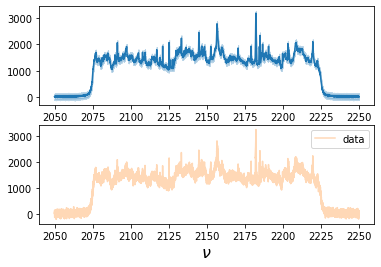

In [34]:
fig=plt.figure()
ax=fig.add_subplot(211)                                                 
ax.plot(nus,median_mu,color="C0")

ax.fill_between(nus, hpdi_mu[0], hpdi_mu[1], alpha=0.3, interpolate=True,color="C0",
                label="90% area")
ax=fig.add_subplot(212) 
ax.plot(nus,F0obs,color="C1",label="data",alpha=0.3)
plt.xlabel("$\\nu$",fontsize=16)

plt.legend()

In [35]:
#reverse
kernel = NUTS(model_c)
mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples)
mcmc.run(rng_key_, nu=nus, y=F0obs)

sample: 100%|█| 300/300 [00:07<00:00, 41.13it/s, 3 steps of size 1.14e-01. acc. 


In [36]:
posterior_sample = mcmc.get_samples()
pred = Predictive(model_c,posterior_sample)
predictions = pred(rng_key_,nu=nus,y=None)
                                                                                    
median_mu = jnp.median(predictions["y"],axis=0)
hpdi_mu = hpdi(predictions["y"], 0.9)

In [37]:
median_mu

DeviceArray([ 8.65174  , 14.269047 , 12.893764 , ..., 17.821861 ,
              4.8471437,  8.417593 ], dtype=float32)

array([[<AxesSubplot:>, None],
       [<AxesSubplot:xlabel='T', ylabel='sigma'>, <AxesSubplot:>]],
      dtype=object)

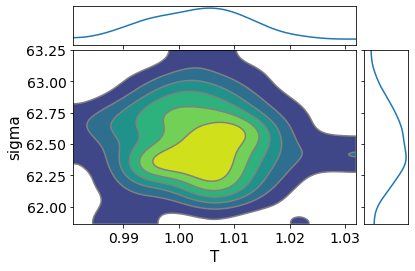

In [38]:
arviz.plot_pair(arviz.from_numpyro(mcmcx),kind='kde',divergences=False,marginals=True,reference_values_kwargs={'color':"red", "marker":"o", "markersize":12})

array([[<AxesSubplot:>, None],
       [<AxesSubplot:xlabel='T', ylabel='sigma'>, <AxesSubplot:>]],
      dtype=object)

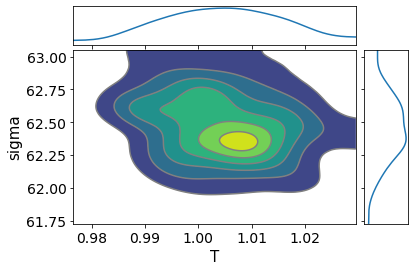

In [39]:
arviz.plot_pair(arviz.from_numpyro(mcmc),kind='kde',divergences=False,marginals=True,reference_values_kwargs={'color':"red", "marker":"o", "markersize":12})